## Аналитика проекта Тинькофф Квест

### Описание проекта:
    Мы открыли новый стартап, занимающийся организацией квестов. 
     
    Проект работает по франшизной системе. Для квестов написаны несколько базовых сценариев, специально приглашёнными для 
    этого креативными агентствами. Попасть на игру можно, забронировав конкретное время и выбрав определённый сценарий. 
     
    Длительность игры 50 минут, за это время игроки должны успеть пройти все задания и только в этом случае игра может
    считаться успешно пройденной, если игрокам понадобится больше времени на прохождение, игра не считается успешно 
    пройденной, а только завершённой. 
     
    Проект уже работает несколько месяцев. Также мы сделали сайт, куда могут заходить наши клиенты. Существует возможность
    регистрации и оформления заявки на бронирование игры по расписанию. 

### Постановка задачи: 
    Нам необходимо посмотреть в динамике, как по неделям и месяцам меняется посещаемость сайта, какая чать клиентов проходит регитсрацию, какая оставляет заявку и сколько в итоге приходит на игру.
    
    На основе полученных данных сделать выводы о том, какие есть слабые места и есть ли точки роста.
    

### Структура базы данных
    За время работы проекта мы успеели собрать определенную базу с данными о ведении нашего бизнеса, использую которую мы можем проводить необходимую аналитику.
    
    Структурно наша модель хранилища данных выглядит следующим образом:
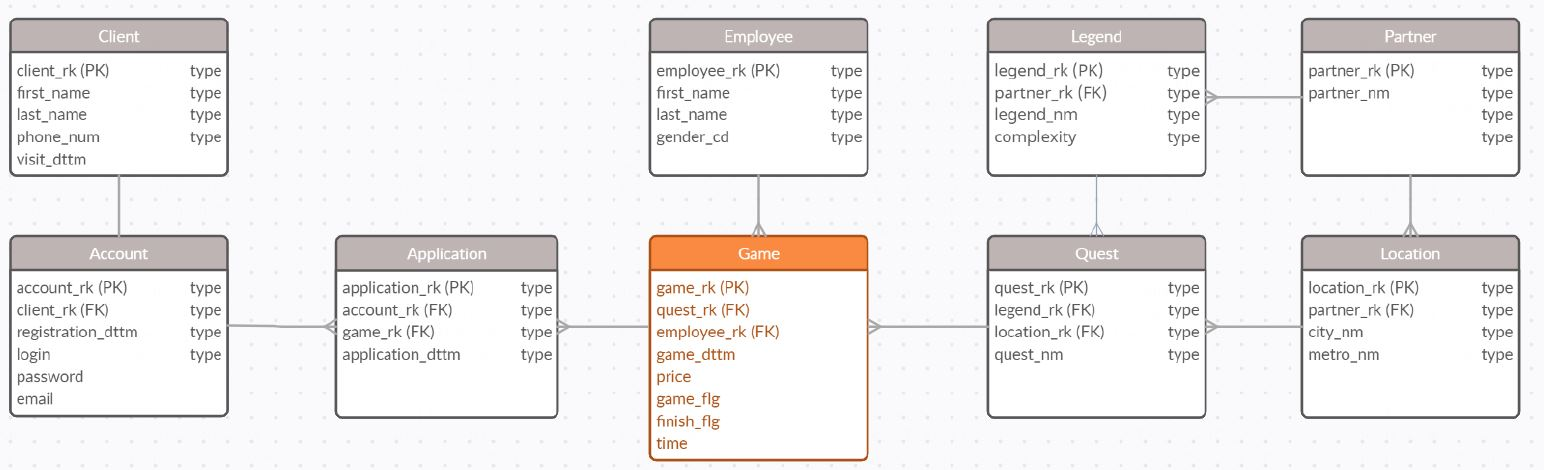
  
  
  table::Partner
  - Partner_rk ID
  - Partner_nm Наименоване партнера
  
  
  table::Locaiton
  - Locaiton_rk ID 
  - Partner_rk ID
  - City_nm Название города
  - Metro_nm Название близайшего метро
  
  
  table::Legend
  - Legend_rk ID
  - Partner_rk ID
  - Legend_nm Название сюжета
  - Complexity  Сложность квеста, в зависимости от сюжета
  
  
  table::Quest
  - Quest_rk ID
  - Legend_rk ID
  - Locaiton_rk ID
  - Quest_nm Название квеста
  
  
  table::Employee
  - Employee_rk ID
  - First_name Имя
  - Last_name Фамилия
  - Gender_cd Пол
  
  
  table::Game
  - Game_rk ID
  - Quest_rk ID
  - Employee_rk ID
  - Game_dttm Дата-время запланированного начала игры
  - Price Стоимость игры
  - Game_flg Флаг того, что игра состоялась
  - Finish_flg Флаг того, что состоявшуюся игру удалось пройти
  - Time Время прохождения игры

  
  table::Client
  - Client_rk ID
  - First_name Имя
  - Last_name Фамилия
  - Phone_num Номер телефона
  - Visit_dttm Дата и время, когда клиент крайний раз посещал сайт
  
  
  table::Account
  - Account_rk ID
  - Client_rk ID
  - Registration_dttm Дата и время регистрации клиента на сайте
  - Login Логин зарегистрированного клиента
  - Password Пароль зарегистрированного клиента
  - Email Адрес электронной почты клиента

  
  table::Application
  - Application_rk ID
  - Account_rk ID
  - Client_rk ID
  - Application_dttm Дата и время заявки на игру клиента


### Алгоритм решения поставленной задачи
   - отберем и обработаем необходимые нам данные из базы
   - будем строить воронку по месяца и неделям
   - рассчитаем Conversion rate для каждого этапа этой воронки
   - визуализируем полученные данные    
   - посмотрим как изменяются показатели в динамике
   - сделаем сообвествующие выводы   

### Используемые модули

In [21]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psycopg2

### Выгрузка данных из DB 

In [9]:
"""
    > Подключаемся к базе данных нашего проекта
    > Формируем DataFrame
    > Пишем SQL запрос, хотим получить общее количество 
    - > посещений, регистраций, заявок и пройденных игр по дням  
    
"""

conn = psycopg2.connect(
    host="158.160.52.106",
    port=5432,
    database="postgres",
    user="***",
    password="***",
)
cur = conn.cursor()


df = pd.read_sql('''

    with visit as (
    select date_trunc('day', visit_dttm) action_date,
           count(distinct client_rk) visits_amount
    from msu_analytics.client c
    group by 1
    ),
    registration as (
    select date_trunc('day', registration_dttm) action_date,
           count(distinct account_rk) as reg_amount
    from msu_analytics.account a
    group by 1
    ),
    application as (
    select date_trunc('day', application_dttm) action_date,
           count(distinct application_rk) application_amount
    from msu_analytics.application a2
    group by 1
    ),
    game as (
    select date_trunc('day', game_dttm) action_date,
           count(distinct game_rk) game_amount
    from msu_analytics.game g
    where game_flg = 1
    group by 1
    )
    select  date_trunc('day', action_date) action_date,
            sum(visits_amount) visits_amount,
            sum(reg_amount) reg_amount,
            sum(application_amount) application_amount,
            sum(game_amount) game_amount
    from visit v
    left join registration r using(action_date)
    left join application a using(action_date)
    left join game g using(action_date)
    group by 1
    order by 1                 
                 
                ''', conn)

In [5]:
"""
    > Получаем сформированный DataFrame df
    
"""
# заполняем NaN занчения нулями
df = pd.read_sql(sql_query, conn).fillna(0)

# приводим к типу datetime
df.action_date = pd.to_datetime(table.action_date)

In [4]:
"""
    > Формируем данные для построеения графика
    > Необходимо сгруппировать данный из табцы по месяцам
    
"""

df_month = df.groupby([pd.Grouper(key='action_date', freq='M')])\
    [['visits_amount', 'reg_amount', 'application_amount', 'game_amount']].sum().reset_index()
df_month

,action_date,visits_amount,reg_amount,application_amount,game_amount
0,2022-09-30,778.0,186.0,63.0,2.0
1,2022-10-31,843.0,219.0,109.0,21.0
2,2022-11-30,786.0,195.0,107.0,43.0
3,2022-12-31,805.0,200.0,97.0,47.0
4,2023-01-31,852.0,215.0,133.0,63.0
5,2023-02-28,32.0,9.0,3.0,3.0


In [5]:
"""
    > Формируем данные для построеения графика
    > Необходимо сгруппировать данный из табцы по неделям
    
"""
df_week = df.groupby([pd.Grouper(key='action_date', freq='W')])\
    [['visits_amount', 'reg_amount',  'application_amount',  'game_amount']].sum().reset_index()
df_week.head()

,action_date,visits_amount,reg_amount,application_amount,game_amount
0,2022-09-04,111.0,22.0,0.0,0.0
1,2022-09-11,184.0,38.0,7.0,0.0
2,2022-09-18,167.0,42.0,17.0,1.0
3,2022-09-25,181.0,46.0,24.0,1.0
4,2022-10-02,195.0,56.0,18.0,1.0


In [7]:
# Так как нам необходимо построить воронку, в которой мы увидим Conversion rate пути клиента
# от посещения сайта до пройденной игры  
# преобразовываем абсолютные велилины в относительные 

def convert_to_percent(col1, col2):
    return pd.Series(data=map(lambda x, y: round((y / x) * 100, 2) if y != 0 else y, col1, col2))

In [29]:
%matplotlib inline

# строим воронку по месяцам
from plotly.subplots import make_subplots
fig = make_subplots(specs=[[{"secondary_y": True}]],rows=1, cols=1)

fig.add_trace(go.Scatter(
    x=df_month['action_date'],
    y=convert_to_percent(df_month['visits_amount'], df_month['reg_amount']),
    showlegend=True, name='% регистраций'),row=1,col=1,secondary_y=False)
fig.add_trace(go.Scatter(
    x=df_month['action_date'],
    y=convert_to_percent(df_month['visits_amount'], df_month['application_amount']),
    showlegend=True, name='% заявок'),row=1,col=1,secondary_y=False)
fig.add_trace(go.Scatter(
    x=df_month['action_date'],
   y=convert_to_percent(df_month['visits_amount'], df_month['game_amount']),
    showlegend=True, name='% состоявшихся игр'),row=1,col=1,secondary_y=False)

fig.add_trace(go.Bar(
    x=df_month['action_date'],
    y=df_month['visits_amount'],
    showlegend=True,opacity=0.3, name='кол-во клиентов'),row=1,col=1,secondary_y=True)

fig.update_layout(title='Воронка Тинькофф квест',xaxis_title='Дата визита', yaxis_title='Конверсия, %')
#fig.show()

Такая визуализация очень лаконична, проста, по ней легко сориентироваться, как выглядят наши конверсии. На одном графике получилось изобразить в динамике % регистрации, заявок, игр от пришедших на сайт клиентов и абсолютное кол-во клиентов на 1 этапе воронки.

In [30]:
%matplotlib inline

# строим воронку по неделям
fig = make_subplots(specs=[[{"secondary_y": True}]],rows=1, cols=1)

fig.add_trace(go.Scatter(
    x=df_week['action_date'],
    y=convert_to_percent(df_week['visits_amount'], df_week['reg_amount']),
    showlegend=True, name='% регистраций'),row=1,col=1,secondary_y=False)
fig.add_trace(go.Scatter(
    x=df_week['action_date'],
    y=convert_to_percent(df_week['visits_amount'], df_week['application_amount']),
    showlegend=True, name='% заявок'),row=1,col=1,secondary_y=False)
fig.add_trace(go.Scatter(
    x=df_week['action_date'],
   y=convert_to_percent(df_week['visits_amount'], df_week['game_amount']),
    showlegend=True, name='% состоявшихся игр'),row=1,col=1,secondary_y=False)

fig.add_trace(go.Bar(
    x=df_week['action_date'],
    y=df_week['visits_amount'],
    showlegend=True,opacity=0.3, name='кол-во клиентов'),row=1,col=1,secondary_y=True)

fig.update_layout(title='Воронка Тинькофф квест',xaxis_title='Дата визита', yaxis_title='Конверсия, %')
#fig.show()

Из построенных графиков можно сделать следующие выводы:
1. Регистрируется на сайте только примерно 25% посетителей
2. С недели 11 декабря 2022 года доля пришедших на игру начала падать (возможно, у нас что-то сломалось, надо проверять). Плюс, мы пока не знаем, сколько дозревают наши игры, т.е. сколько времени проходит от посещения сайта до состоявшейся игры. Может быть, конверсия в игру еще недозрела. Однако если бы причина была только в этом, то с 12 декабря по 23 января мы бы наблюдали плавный спад, а у нас метрика резко упала к 25 декабря. Возможно, здесь и эффект недозревших данных и что-то у нас пошло не так в процессе.
3. Число посетителей сайта не растет
4. На неделе 13 ноября была резкая просадка по конверсии в заявку (что там произошло?)

Точки роста продукта:
1. Привлечение новой аудитории (посещения сайта не растут, надо развивать привлечение)
2. Разобраться, почему конверсия в игру полетела вниз (сформулировать гипотезы и пойти их проверять)
3. Видно, что у нас хорошая конверсия из заявки в состоявшуюся игру. Но на этапе регистрация - заявка отваливается много клиентов (примерно 70% от зарегистрированных не доходят до заявки). Можно подумать, как вовлекать больше зарегистрированных клиентов в продукт.
4. Только 25% клиентов регистрируется на сайте. А нужен ли нам вообще этот этап в процессе? Возможно, стоит подумать над упрощением клиентского пути, ведь чем быстрее путь - тем выше конверсия в целевое действие (в состоявшуюся игру).